In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
import cmocean.cm as cmo
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import scipy
from datetime import datetime,timedelta
from xmovie import Movie
import nfft
import xrft

%matplotlib inline

In [2]:
# input_path = '/home/hgrosselindemann/Documents/GitHub/TORI/'
input_path = '/Users/2311043/Documents/GitHub/TORI/'


grid_data = scipy.io.loadmat(input_path + 'TOROS_grids_f.mat')
vel_data = scipy.io.loadmat(input_path + '201503.mat')

In [3]:
time = np.arange(datetime(2015,3,1,0,0,0), datetime(2015,4,1,0,0,0), timedelta(hours=1)).astype(datetime)

In [4]:
flag = xr.Dataset(coords={
    'lat':(['y','x'],grid_data['lat0']),
    'lon':(['y','x'],grid_data['lon0'])
},data_vars={
    'flag':(['y','x'],grid_data['flag0'])
})

velocity = xr.Dataset(coords={
    'lat':(['y','x'],grid_data['lat0']),
    'lon':(['y','x'],grid_data['lon0']),
    'time':(['time'],time)
},data_vars={
    'u':(['y','x','time'],vel_data['u0_monthly']),
    'v':(['y','x','time'],vel_data['v0_monthly'])
})

velocity = velocity.transpose('time','y','x')

velocity['u'] = velocity['u'].where(flag.flag==0)
velocity['v'] = velocity['v'].where(flag.flag==0)
velocity['abs'] = np.sqrt(velocity['u']**2 + velocity['v']**2)

# seasonal means

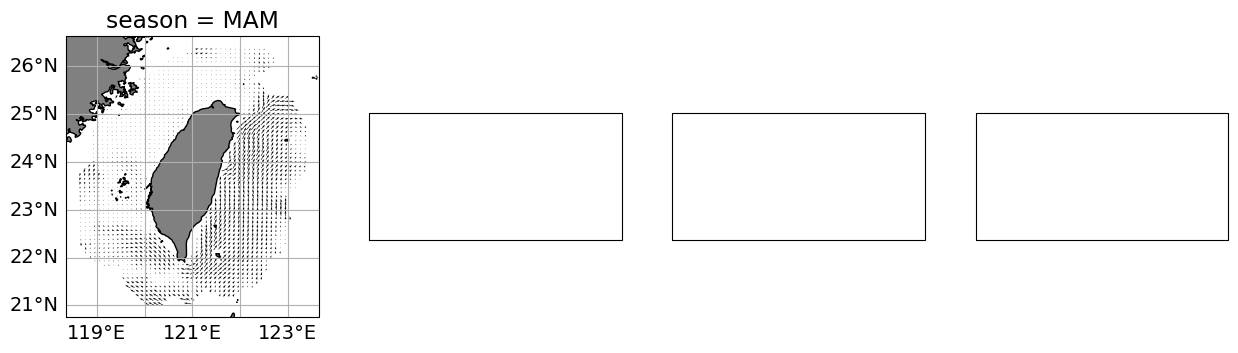

In [139]:
fig,(ax1,ax2,ax3,ax4) = plt.subplots(1,4,figsize=(15,5),subplot_kw={'projection':ccrs.PlateCarree()})
velocity.groupby('time.season').mean(dim='time').sel(season='MAM').plot.quiver('lon','lat','u','v',ax=ax1)
ax1.add_feature(cfeature.LAND, facecolor='grey',edgecolor='black')
gl1 = ax1.gridlines(draw_labels=True)
gl1.top_labels=False
gl1.right_labels=False

# Movie

In [9]:
fig = plt.figure(figsize=(10,10))

def custom_plotfunc(ds,fig,tt,framedim='time',**kwargs):
    ax = fig.subplots(subplot_kw={'projection':ccrs.PlateCarree()})
    ds.isel({framedim:tt}).plot.quiver('lon','lat','u','v',ax=ax)
    ax.add_feature(cfeature.LAND, facecolor='grey',edgecolor='black')
    ax.gridlines(draw_labels=True)
    return None,None
    
# mov = Movie(velocity,custom_plotfunc,input_check=False)
# mov.save('movie_2015.mp4',overwrite_existing=True,framerate=8)

<Figure size 1000x1000 with 0 Axes>

# De-mean and De-trend

In [5]:
def demean_xarray(da,dim):
    return da - da.mean(dim=dim)

def detrend_xarray(da):
    dt = xr.apply_ufunc(
                linear_detrend,
                da,
                input_core_dims=[['time']],
                output_core_dims=[['time']],
                vectorize=True,
                output_dtypes=[da.dtype],
                dask="parallelized",
            )
    dt = dt.transpose('time','y','x')
    return dt

def linear_detrend(da):
    ds = da.copy()
    mask = ~np.isnan(ds)
    if mask.sum() == 0:
        return ds
    else:
        ds_masked = ds[mask]
        time_masked = np.arange(0,len(ds))[mask]
        coeff = np.polyfit(time_masked, ds_masked, 1)
        trend = np.polyval(coeff, time_masked)
        detrended = ds_masked - trend
        ds[mask] = detrended
        return ds

In [6]:
velocity['u_demeaned'] = demean_xarray(velocity.u,dim='time')
velocity['u_detrended'] = detrend_xarray(velocity['u_demeaned'])

velocity['v_demeaned'] = demean_xarray(velocity.v,dim='time')
velocity['v_detrended'] = detrend_xarray(velocity['v_demeaned'])

# interpolation

In [22]:
test = velocity.u[:,10,10].copy()
dummy = test.interpolate_na(dim='time',method='linear')

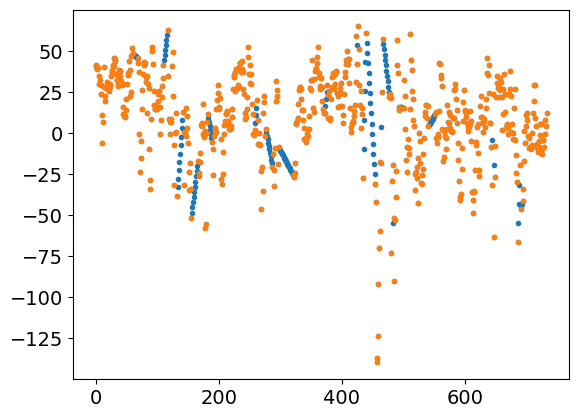

In [23]:
plt.plot(dummy,'.')
plt.plot(test,'.')


# Spectral analysis

## uniform FFT

In [6]:
# try xrft.power_spectrum

In [35]:
def spectrum1(h, dt=1):
    """
    First cut at spectral estimation: very crude.
    
    Returns frequencies, power spectrum, and
    power spectral density.
    Only positive frequencies between (and not including)
    zero and the Nyquist are output.
    """
    nt = len(h)
    npositive = nt//2
    pslice = slice(1, npositive)
    freqs = np.fft.fftfreq(nt, d=dt)[pslice] 
    ft = np.fft.fft(h)[pslice]
    psraw = np.abs(ft) ** 2
    # Double to account for the energy in the negative frequencies.
    psraw *= 2
    # Normalization for Power Spectrum
    psraw /= nt**2
    # Convert PS to Power Spectral Density
    psdraw = psraw * dt * nt  # nt * dt is record length
    return freqs, psraw, psdraw

In [36]:
mask = ~np.isnan(u_detrended[:,10,10].interpolate_na(dim='time',method='linear'))
freq,ps,psd = spectrum1(u_detrended[:,10,10].interpolate_na(dim='time',method='linear')[mask])

## non-uniform DFT

In [129]:
def nudft(data,xarray_apply=True):
    '''
    does a non-uniform discrete fourier transform on data with a uniform grid but nan values in it
    
    returns freq: frequency in cycles per timestep (cph for hourly data)
            f_k: amplitude for each wavenumber k as a complex number
            ps: power spectrum
            psd: power spectral density
            
    xarray_apply is used for the spectral_analysis function for apply_ufunc along time dimension for each point of spatial array
        if you just want to do it for one array time series, set it to False
    
    function is taken from https://github.com/jakevdp/nfft
    '''
    mask = ~np.isnan(data)
    
    N_freq = len(data)
    k = -N_freq//2 + np.arange(N_freq)
    
    data_masked = data[mask]
    t = np.linspace(0, 1,N_freq)[mask]
    
    f_k = nfft.ndft_adjoint(t,data_masked,N_freq)
    ps = np.abs(f_k)**2/N_freq**2
    psd = ps * N_freq
    freq = k/N_freq
    if xarray_apply == True:
        t_return = np.linspace(0, 1,N_freq)
        t_return[~mask] = np.nan
        return np.stack((freq,f_k,ps,psd,t_return),axis=-1)
    elif xarray_apply==False:
        return freq,f_k,ps,psd,t

In [269]:
def spectral_analysis(da):
    dt = xr.apply_ufunc(
                nudft,
                da,
                input_core_dims=[['time']],
                output_core_dims=[['freq','dim0']],
                vectorize=True,
                output_dtypes=['complex'],
                dask="parallelized",
                dask_gufunc_kwargs={'output_sizes':{'freq':(744,5)}}
            )
    dt = xr.Dataset(coords={
        'lat':(['y','x'],dt['lat'].data),
        'lon':(['y','x'],dt['lon'].data),
        'freq':np.real(dt[0,0,:,0].data)
    },data_vars={
        'f_k':(['y','x','freq'],dt.isel(dim0=1).data),
        'ps':(['y','x','freq'],np.real(dt.isel(dim0=2).data)),
        'psd':(['y','x','freq'],np.real(dt.isel(dim0=3).data)),
        't':(['y','x','freq'],np.real(dt.isel(dim0=4).data))
        

    })
    dt = dt.transpose('freq','y','x')
    dt = dt.where(dt!=0)
    return dt

# spectral_u = spectral_analysis(velocity.u_detrended)
# spectral_v = spectral_analysis(velocity.v_detrended)
hann = xr.DataArray(coords={'time':velocity.time.values},data=np.hanning(744))
spectral_u_hann = spectral_analysis(velocity.u_demeaned*hann)

# spectral_rotary = spectral_analysis(velocity.u_detrended+1j*velocity.v_detrended)

In [284]:
freq,f_k,ps,psd,t = nudft(velocity.u_detrended[:,10,10],xarray_apply=False)
freq,f_k_filtered,ps_filtered,psd_filtered,data_reconstructed_filtered = nudft(velocity.u_filtered[:,10,10],xarray_apply=False)

In [10]:
freq_pos = freq[372:]

f_k_pos = np.ones((372))*f_k[372:]
f_k_pos[1:] = f_k_pos[1:]*2

ps_pos = np.ones((372))*ps[372:]
ps_pos[1:] = ps_pos[1:]*2

psd_pos = np.ones((372))*psd[372:]
psd_pos[1:] = psd_pos[1:]*2

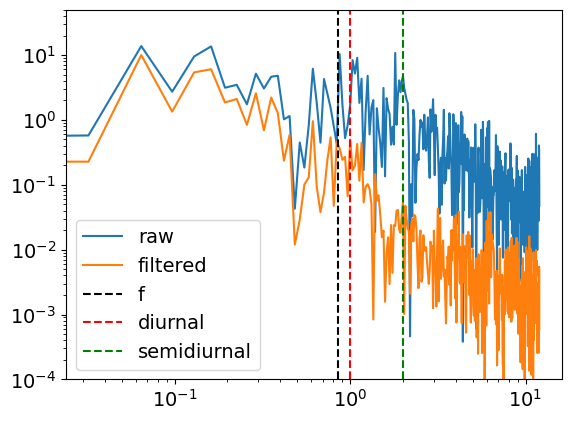

In [286]:
f_coriolis = 2*7.29e-5*np.sin(25/180*np.pi)/2/np.pi*3600*24

plt.loglog(freq*24,ps,label='raw')
plt.loglog(freq*24,ps_filtered,label='filtered')

# plt.loglog(spectral_u_hann.isel(x=10,y=10).freq*24,spectral_u_hann.isel(x=10,y=10).ps,label='hann')
# plt.loglog(spectral_u.isel(x=10,y=10).freq*24,spectral_u.isel(x=10,y=10).ps,label='detrend')


# plt.loglog(freq*24,ps_filtered)

ymin,ymax = 1e-4,5e1
plt.vlines([f_coriolis],ymin,ymax,color=['k'],linestyle='--',label='f')
plt.vlines([1],ymin,ymax,color=['r'],linestyle='--',label='diurnal')
plt.vlines([2],ymin,ymax,color=['g'],linestyle='--',label='semidiurnal')

plt.legend(loc='lower left')
plt.ylim([ymin,ymax]);

# plt.savefig('/Users/2311043/Documents/GitHub/TORI/spectrum_filtervsraw.png')

## Rotary spectrum

In [293]:
freq,f_k,ps,psd,t = nudft(velocity.u_detrended[:,10,10]+1j*velocity.v_detrended[:,10,10],xarray_apply=False)
freq,f_k_filtered,ps_filtered,psd_filtered,t = nudft(velocity.u_filtered[:,10,10]+1j*velocity.v_filtered[:,10,10],xarray_apply=False)

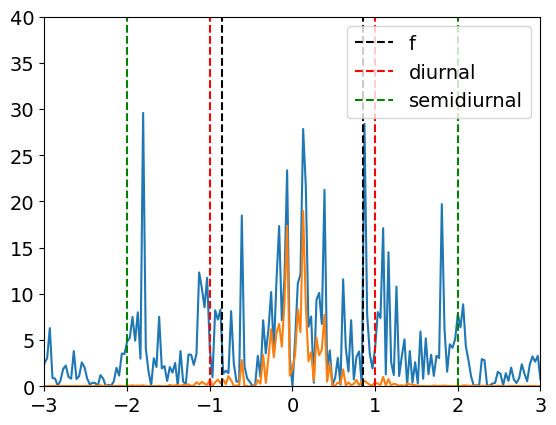

In [294]:
f_coriolis = 2*7.29e-5*np.sin(25/180*np.pi)/2/np.pi*3600*24

plt.plot(freq*24,ps)
plt.plot(freq*24,ps_filtered)

plt.xlim([-3,3])
ymin,ymax = 0,40
plt.vlines([f_coriolis,-f_coriolis],ymin,ymax,color=['k'],linestyle='--',label='f')
plt.vlines([1,-1],ymin,ymax,color=['r'],linestyle='--',label='diurnal')
plt.vlines([2,-2],ymin,ymax,color=['g'],linestyle='--',label='semidiurnal')
plt.legend()
plt.ylim([ymin,ymax]);

# time filtering

In [131]:
def hann_window(T,n):
    w = np.hanning(T)
    w = w / w.sum()
    freq_hann = np.fft.fftfreq(n)

    w_transform = np.abs(np.fft.fft(w, n=n))
    amp_hann = np.concatenate((w_transform[372:],w_transform[:372]))
    freq_hann = np.concatenate((freq_hann[372:],freq_hann[:372]))
    return freq_hann,amp_hann

In [112]:
def drop_na(data):
    mask = ~np.isnan(data)
    return data[mask]

In [252]:
def inverse_nudft(data):
    reconstructed = nfft.ndft(drop_na(data.t), data.f_k)/len(data.f_k)
    reconstructed_ontime = np.copy(data.t)
    reconstructed_ontime[~np.isnan(data.t)] = reconstructed
    return reconstructed_ontime

# def inverse_nudft_hann(data,amp_hann):
#     reconstructed = nfft.ndft(drop_na(data.t), data.f_k*amp_hann)/len(data.f_k)
#     reconstructed_ontime = np.copy(data.t)
#     reconstructed_ontime[~np.isnan(data.t)] = reconstructed
#     return reconstructed_ontime

def inverse_nudft_hann(t,f_k,amp_hann):
    reconstructed = nfft.ndft(drop_na(t), f_k*amp_hann)/len(f_k)
    reconstructed_ontime = np.copy(t)
    reconstructed_ontime[~np.isnan(t)] = reconstructed
    return reconstructed_ontime

In [211]:
data_rec = inverse_nudft(spectral_u.isel(x=10,y=10))
data_filtered = inverse_nudft_hann(spectral_u.isel(x=10,y=10).t,spectral_u.isel(x=10,y=10).f_k,amp_hann)

C:\Users\2311043\AppData\Local\Temp\ipykernel_11308\670657169.py:4: ComplexWarning: Casting complex values to real discards the imaginary part
  reconstructed_ontime[~np.isnan(data.t)] = reconstructed
C:\Users\2311043\AppData\Local\Temp\ipykernel_11308\670657169.py:16: ComplexWarning: Casting complex values to real discards the imaginary part
  reconstructed_ontime[~np.isnan(t)] = reconstructed


In [274]:
def filter_hann_window(spectral_data,T):
    freq_hann,amp_hann = hann_window(T,len(spectral_data.freq))
    dt = xr.apply_ufunc(
                inverse_nudft_hann,
                spectral_data.t,
                spectral_data.f_k,
                amp_hann,
                input_core_dims=[['freq'],['freq'],['time']],
                output_core_dims=[['time']],
                vectorize=True,
                output_dtypes=[np.dtype(float)],
                dask="parallelized",
            )
    dt = dt.transpose('time','y','x').assign_coords({'time':velocity.time.values})
    return dt

u_filtered_hann = filter_hann_window(spectral_u_hann,49)
# v_filtered = filter_hann_window(spectral_v,49)

velocity['u_filtered_hann'] = u_filtered_hann
# velocity['v_filtered'] = v_filtered

C:\Users\2311043\AppData\Local\Temp\ipykernel_11308\670657169.py:16: ComplexWarning: Casting complex values to real discards the imaginary part
  reconstructed_ontime[~np.isnan(t)] = reconstructed


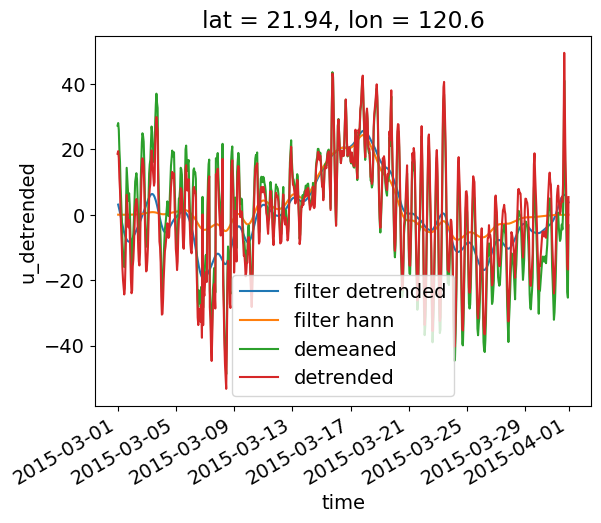

In [281]:
(velocity.isel(x=20,y=10).u_filtered).plot(label='filter detrended')
velocity.isel(x=20,y=10).u_filtered_hann.plot(label='filter hann')
velocity.isel(x=20,y=10).u_demeaned.plot(label='demeaned')
velocity.isel(x=20,y=10).u_detrended.plot(label='detrended')
plt.legend()
plt.savefig('/Users/2311043/Documents/GitHub/TORI/time_filter.png')

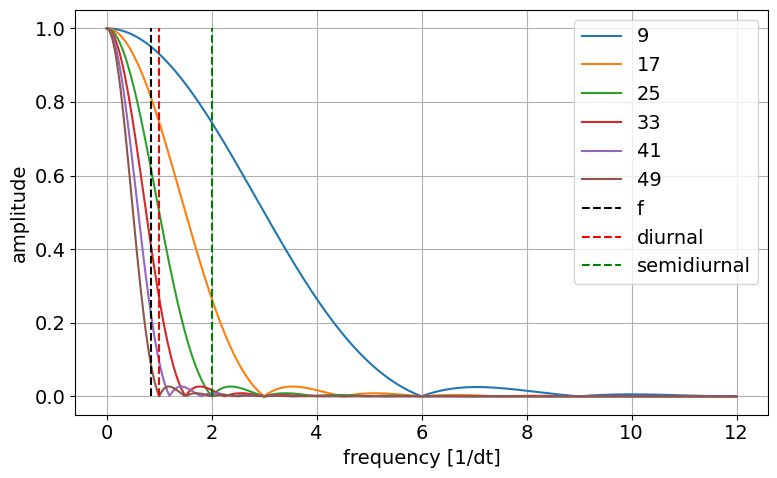

In [54]:
n = 744
fig, axs = plt.subplots(1, 1, figsize=(8, 5), sharex=True)
axs = [axs]
# axs[0].plot(freq_pos*24,ps_pos/ps_pos.max(),label='power spectrum')

for k in np.arange(4, 28, 4):
    T = 2 * k + 1
#     w = np.zeros(n)
#     w[n//2 - k : n//2+k+1] = np.hanning(T)
    w = np.hanning(T)
    w = w / w.sum()
    freq_hann = np.fft.rfftfreq(n)
    w_transform = np.fft.rfft(w, n=n)
#     w_transform = np.ones_like(freq)
#     w_transform = (
#         0j 
#         + .5 * T * np.sinc(freq * T)
#         + .25 * T * np.sinc(T * (freq - 1 / T))
#         + .25 * T * np.sinc(T * (freq + 1 / T))
#     )
    w_transform /= w_transform[0]
    w_power = w_transform * w_transform.conj()

    plt.sca(axs[0])
    plt.plot(freq_hann*24, np.abs(w_transform),label=str(T))
    
#     plt.sca(axs[1])
#     plt.plot(freq, np.angle(w_transform), )

axs[0].set(ylabel='amplitude', xlabel='frequency [1/dt]')
axs[0].grid()

ymin,ymax = 0,1
plt.vlines([f_coriolis],ymin,ymax,color=['k'],linestyle='--',label='f')
plt.vlines([1],ymin,ymax,color=['r'],linestyle='--',label='diurnal')
plt.vlines([2],ymin,ymax,color=['g'],linestyle='--',label='semidiurnal')
plt.legend()

# axs[1].set(ylabel='phase')
# axs[1].grid()
plt.tight_layout();
# plt.savefig('../img/9_filtering_4.svg', bbox_inches='tight', pad_inches=.1);

# Parcels

In [196]:
from parcels import FieldSet, ParticleSet, Variable, JITParticle, AdvectionRK4, plotTrajectoriesFile
import numpy as np
import math
from datetime import timedelta
from operator import attrgetter

In [149]:
velocity.u.to_netcdf('/Users/2311043/Documents/TOROS_U_0315.nc')
velocity.v.to_netcdf('/Users/2311043/Documents/TOROS_V_0315.nc')

In [197]:
filenames = {'U': "/Users/2311043/Documents/TOROS_U_0315.nc",
             'V': "/Users/2311043/Documents/TOROS_V_0315.nc"}
variables = {'U': 'u',
             'V': 'v'}
dimensions = {'lat': 'lat',
              'lon': 'lon',
              'time': 'time'}
fieldset = FieldSet.from_netcdf(filenames, variables, dimensions)

In [198]:
pset = ParticleSet.from_line(fieldset=fieldset, pclass=JITParticle,
                             size=5,            # releasing 5 particles
                             start=(121, 22),   # releasing on a line: the start longitude and latitude
                             finish=(121.5, 22))  # releasing on a line: the end longitude and latitude

In [199]:
output_file = pset.ParticleFile(name="/Users/2311043/Documents/TOROS_Parcels/toros.zarr", outputdt=timedelta(hours=6))
pset.execute(AdvectionRK4,
             runtime=timedelta(days=1),
             dt=timedelta(minutes=5),
             output_file=output_file)

INFO: Compiled ArrayJITParticleAdvectionRK4 ==> C:\Users\2311043\AppData\Local\Temp\parcels-tmp\lib0cef196e3e2f85a18c88e5a9d3aa42fb_0.dll


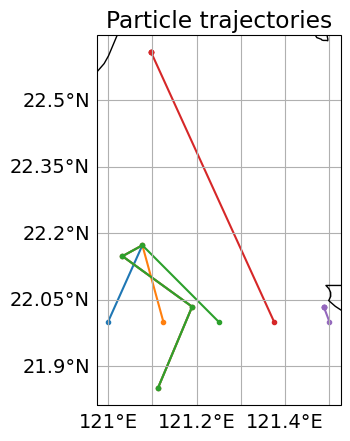

<module 'matplotlib.pyplot' from 'C:\\Users\\2311043\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

In [200]:
plotTrajectoriesFile("/Users/2311043/Documents/TOROS_Parcels/toros.zarr")

In [201]:
data = xr.open_zarr("/Users/2311043/Documents/TOROS_Parcels/toros.zarr").load()

In [203]:
data

<xarray.Dataset>
Dimensions:     (trajectory: 5, obs: 5)
Coordinates:
  * obs         (obs) int32 0 1 2 3 4
  * trajectory  (trajectory) int64 35 36 37 38 39
Data variables:
    lat         (trajectory, obs) float32 22.0 22.17 22.15 ... 22.03 22.03 22.03
    lon         (trajectory, obs) float32 121.0 121.1 121.0 ... 121.5 121.5
    time        (trajectory, obs) datetime64[ns] 2015-03-01 ... 2015-03-02
    z           (trajectory, obs) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
Attributes:
    Conventions:            CF-1.6/CF-1.7
    feature_type:           trajectory
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_mesh:           spherical
    parcels_version:        2.4.1